# Week 1 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = r"C:\Users\iarak\OneDrive\Desktop\CCA\Movies"

#corpus_name = "Movies"

This method extracts the text from the zip files and stores the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

Let's look at what the code chunk above does. 

First, "def" function literally defines a function. You can call the function that you defined by using the function name, which is, here, loadcorpus. 

Second, it might be obvious, but, in Python, + operator is used when you combine literal strings or string variables. So, "corpus_name" + "/" gets you "corpus_name/". For example, in my case, the corpus_name is 'Users/hyunkukwon/Downloads/Movies'; so, corpus_name + "/" gives me '/Users/hyunkukwon/Downloads/Movies/'. By the way, why do we use "" here? This is because / is an operator in itself. Using "" makes / a string rather than an operator. Just to let you know, you can use type() to see what's the type of something. For example, if you write type(corpus_name), it'll get you 'string'.

Third, the "os.listdir" function is used to get the list of files in the specified directory. So, here we're trying to get all the files in the directory. 

But we have some problems here: 

(1) first problem is that we do not want to load all the files in this directory; we want to load the files that have 'text' in the file name. So, we use the "if corpus_style in file:" to get the files that have the textual characteristics that we specified when we defined the function (corpus_style = "text"). Just to clarify, specifying the corpus_style does not get us the txt. files (in other words, it's not about the file extension). 

(2) second problem is that the files we have are zip files. So, we should unzip it so that we can get them on Python. That's why we use ZipFile, a class of zipfile module. We use ZipFile to read and write zip files. Then we use namelist() function, which returns the list of archive members by name.

Finally, append() function adds an item at the end of the list. Here, we make an empty list by doing "texts_raw[file] = []"; and then we open the file, get every line in the file, and then append it to the empty list. The for loop does the iteration. 

By the way, we used something similar above: "texts_raw = {}". But they're different: {} is a dictionary, while [] is a list. 

In [4]:
movie_raw = loadcorpus(corpus_name)

text_00_myn.zip
text_01_ote.zip
text_02_mqu.zip
text_03_mnq.zip
text_04_mlq.zip
text_05_nko.zip
text_06_jfy.zip
text_07_oma.zip
text_08_loh.zip
text_09_oii.zip
text_10_aoy.zip
text_11_uoy.zip
text_12_rcq.zip
text_13_idi.zip
text_14_lnc.zip
text_15_guo.zip
text_16_qll.zip
text_17_arp.zip
text_18_jfj.zip
text_19_gvc.zip
text_20_cde.zip
text_21_fqa.zip
text_22_etp.zip
text_23_fmh.zip
text_24_ywo.zip
text_25_byg.zip
text_26_ngj.zip
text_27_fle.zip
text_28_rfy.zip
text_29_oye.zip
text_30_wkp.zip
text_31_akv.zip
text_32_ldf.zip
text_33_kje.zip


Why do we get this list of files? Because of the "print(file)" in the code chunk above. So, the list here involves all the files that have "text" in their file name. 

Let's look at one of the files:

In [5]:
movie_raw['18.txt'][0:3]

[b'\r\n',
 b"@@5269815 Now listen here , fat-head We 're back home again and that 's because we did a little fighting And I know what you 're thinking You 're thinking : Well , here comes us The Foreign Legion Each man a hero all the booze in the world made for us and the women thrown in But you 're wrong . this time , you 're gon na behave yourselves like gentlemen even if it 'll kill you Yes , I 'm talking to you you heard what I said ! Why do n't you get back in line ? What are doing with your fingers ? - Nothing ... yet - get in there - all packed up , Sir . ready to land - Thank you . There you are . I hope I have n't forgotten anything . Merci , Monsieur . you 're very kind Your first voyage to Morocco ? Yes . I make the trip quite often . perhaps I can be of some service ? I 'd be happy to help you I wo n't need any help You can always reach me at this address , Mademoiselle . Merci , Monsieur @ @ @ @ @ @ @ @ @ @ know who that woman is ? A vaudeville actress probably just how do

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d").replace(" \'d", "'d'")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

Now we're familiar with the code structure (such as for loop) as well as some functions (such as append). Let's briefly look at the functions that didn't appear above.

replace() is a Python built-in function for strings. What it does is: it replaces the one that comes before with the one that comes later. The syntax of this function is the following: str.replace(old, new[, max]). The [, max] part is optional, and we didn't use it here. For example, text.replace(" \'m", "'m") literally replaces /'m with 'm. 

decode() is a function which literally converts from one encoding scheme to the other one.

In [7]:
clean_18 = clean_raw_text(movie_raw['18.txt'])

In [9]:
clean_18[1]

"@@5269815 Now listen here , fat-head We're back home again and that's because we did a little fighting And I know what you're thinking You're thinking : Well , here comes us The Foreign Legion Each man a hero all the booze in the world made for us and the women thrown in But you're wrong . this time , you're gon na behave yourselves like gentlemen even if it'll kill you Yes , I'm talking to you you heard what I said ! Why don't you get back in line ? What are doing with your fingers ? - Nothing ... yet - get in there - all packed up , Sir . ready to land - Thank you . There you are . I hope I haven't forgotten anything . Merci , Monsieur . you're very kind Your first voyage to Morocco ? Yes . I make the trip quite often . perhaps I can be of some service ? I'd' be happy to help you I won't need any help You can always reach me at this address , Mademoiselle . Merci , Monsieur @ @ @ @ @ @ @ @ @ @ know who that woman is ? A vaudeville actress probably just how do you figure that ? we ca

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [8]:
import spacy
import en_core_web_sm

In [9]:
nlp = spacy.load('en_core_web_sm')

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

Let's look at the cell above. What are we doing here? We want to tokenize the corpus, i.e. split the text into minimal meaningful units. To do so, we collect tokens in the document that is neither punctuation (e.g. "?", ",", "!" etc) nor the ones the length of which is not bigger than 0. is_punct tells you if a token is a punctuation or not; so, we use "if not" to weed out punctuations. len(token.text.strip()) gets you the length of each string; so, we remove strings the length of which is not bigger than 0. By the way, strip() function here returns a copy of the wtring with both leading and trailing characters stripped. Since we didn't specify any characters, it merely removes the spaces before and after each string.

In [11]:
word_tokenize(clean_18[1])

['@@5269815',
 'Now',
 'listen',
 'here',
 'fat',
 'head',
 'We',
 "'re",
 'back',
 'home',
 'again',
 'and',
 'that',
 "'s",
 'because',
 'we',
 'did',
 'a',
 'little',
 'fighting',
 'And',
 'I',
 'know',
 'what',
 'you',
 "'re",
 'thinking',
 'You',
 "'re",
 'thinking',
 'Well',
 'here',
 'comes',
 'us',
 'The',
 'Foreign',
 'Legion',
 'Each',
 'man',
 'a',
 'hero',
 'all',
 'the',
 'booze',
 'in',
 'the',
 'world',
 'made',
 'for',
 'us',
 'and',
 'the',
 'women',
 'thrown',
 'in',
 'But',
 'you',
 "'re",
 'wrong',
 'this',
 'time',
 'you',
 "'re",
 'gon',
 'na',
 'behave',
 'yourselves',
 'like',
 'gentlemen',
 'even',
 'if',
 'it',
 "'ll",
 'kill',
 'you',
 'Yes',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'you',
 'heard',
 'what',
 'I',
 'said',
 'Why',
 'do',
 "n't",
 'you',
 'get',
 'back',
 'in',
 'line',
 'What',
 'are',
 'doing',
 'with',
 'your',
 'fingers',
 'Nothing',
 'yet',
 'get',
 'in',
 'there',
 'all',
 'packed',
 'up',
 'Sir',
 'ready',
 'to',
 'land',
 'Thank',
 'yo

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

What's going on here? We first make an empty dictionary (by the way, if you're not familiar with dictionaries, you should go look it up online.) Then, we go through each word in the word list one by one with the for loop. If the word that the loop is looking at has appeared before, we add one more to the number("+=1"); if it didn't appear before, we assign one to the word ("= 1"). 

And then we convert it to DataFrame. Why do we use wordCounts.items() here? Because the wordCounts that we defined above is a dictionary; and items() returns the list of all dictionary keys with values. And then we use pandas.DataFrame to convert this dictionary to DataFrame.

In [13]:
countedWords = wordCounter(word_tokenize(clean_18[1]))
countedWords[:10]

word  count
0  @@5269815      1
1        now     11
2     listen      1
3       here     15
4        fat      1
5       head      1
6         we     20
7        're     18
8       back      7
9       home      2

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
22     you    170
19       i    159
27     the    100
64     n't     65
59      to     64
..     ...    ...
216     or      7
320    les      7
387  apple      7
196     as      7
8     back      7

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

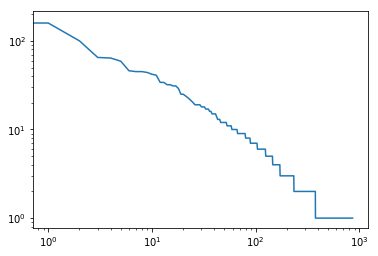

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in a few weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [21]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [22]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [23]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [24]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [25]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [17]:
import nltk

In [27]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [28]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [29]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

In [30]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [31]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [32]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [33]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [34]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

But before we proceed: what is the lambda function here? What the lambda function does here is that it iterates over the list row by row and applies the function, e.g. word_tokenize() or len(), to each list. So, it looks similar to for loop; but, lambda is an expression while for loop is a statement. I won't elaborate on the difference between these two here for space limitations. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [19]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [20]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [21]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [222]:
movie_texts = {}

In [223]:
for files in movie_raw:
    if len(movie_texts) > 1000:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie) #whenever I would sub the word_tokenize function for 
                                                        #nltk or nltk.tokenize.word_tokenize, it would get stuck
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [ ]:
"""for files in movie_raw:
    if len(movie_texts) > 2: # doing it for all the scripts (>0) is taking too long so doing it for only 1000 right now
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = word_tokenize(movie) #nltk word tokenize function using nlp 
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue"""

In [37]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iarak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
#movie_texts_nltk = {}

In [ ]:
"""#used the word tokenize function that was made so this is not needed
for files in movie_raw:
    if len(movie_texts_nltk) > 1000:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts_nltk = nltk.tokenize.word_tokenize(movie)
        try:
            movie_texts_nltk[txts_nltk[0][2:]] = txts_nltk[1:]
        except IndexError:
            continue"""

In [38]:
import pandas as pd

In [224]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country","IMDb", "Tokenized"])

In [225]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), imdb.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [226]:
movie_df['Word_Counts'] = movie_df['Tokenized'].apply(lambda x: len(x))

In [74]:
movie_df.head(15)

Movie Name                      Genre  Year  \
3435788                 Born Reckless    Crime, Drama, Film-Noir  1930   
6880640                    Dishonored        Drama, Romance, War  1931   
5482259                    Indiscreet     Comedy, Drama, Musical  1931   
5192597              The Stolen Jools              Comedy, Short  1931   
3982760                 College Humor                     Comedy  1933   
6081152                  Man's Castle             Drama, Romance  1933   
6474875            Sons of the Desert                     Comedy  1933   
3490059                 Tugboat Annie              Comedy, Drama  1933   
3698573               Zoo in Budapest             Drama, Romance  1933   
3546646                    Blue Steel                    Western  1934   
6100453             Imitation of Life             Drama, Romance  1934   
6880011                One More River             Drama, Romance  1934   
6276470                Ready for Love                    Romance  1934   
4613566  The Grasshopper and the Ants  Family, Comedy, Animation  1934   
4543651          Three Orphan Kittens  Animation, Comedy, Family  1935   

                          Country     IMDb  \
3435788  English, Italian, French  0020702   
6880640                   English  0021800   
5482259                   English  0022000   
5192597                   English  0022402   
3982760                   English  0023900   
6081152                   English  0024302   
6474875                   English  0024601   
3490059                   English  0024701   
3698573                   English  0024800   
3546646                   English  0024902   
6100453                   English  0025301   
6880011                   English  0025600   
6276470                   English  0025702   
4613566                   English  0025200   
4543651                   English  0027100   

                                                 Tokenized  Word_Counts  
3435788  [Louis, Louis, Beretti, Shh, Put, that, out, y...         6514  
6880640  [I, thought, I, smelled, gas, That, 's, three,...         3405  
5482259  [Subtitles, Lu, s, Filipe, Bernardes, Wait, Yo...         6247  
5192597  [Subtitles, Lu, s, Filipe, Bernardes, Hello, W...         2180  
3982760  [Play, ball, Although, the, game, seems, uphil...         8856  
6081152  [What, 's, the, matter, Come, on, spill, it, I...         7998  
6474875  [And, here, 's, a, hand, my, trusty, friend, A...         5052  
3490059  [HEY, MOM, WHAT, IS, IT, SON, LISTEN, IF, A, F...         8375  
3698573  [A, fish, for, a, penny, Thank, you, A, fish, ...         4571  
3546646  [Here, we, are, born, to, be, kings, We, 're, ...         4426  
6100453  [Want, my, quack, quack, No, darling, not, now...        12074  
6880011  [It, 's, devastating, Things, coming, to, an, ...        10624  
6276470  [Hello, Shush, Hey, Well, Do, n't, put, me, of...         8242  
4613566  [Ha, ha, ha, ha, ha, Come, here, son, Listen, ...          205  
4543651  [THREE, ORPHAN, KITTENS, Hallelujah, Hole, in,...          153

Examining one specific text to extract different themes based on what is most popular count wise - through my project I'm hoping to examine what are the most lucrative/ best reviewed scripts and will later be joining with a revenue dataset as done in part1 of week 0's homework but for now I will see what themes can be extracted from one text file and then scale up for all text files.

#### Examining the Comedy film College Humor

In [59]:
Ready_for_love = movie_df['Tokenized'][12]

In [60]:
Ready_for_love

['Hello',
 'Shush',
 'Hey',
 'Well',
 'Do',
 "n't",
 'put',
 'me',
 'off',
 'mister',
 'please',
 'I',
 "'m",
 'in',
 'an',
 'awful',
 'hurry',
 'A',
 'matter',
 'of',
 'life',
 'and',
 'death',
 'Yeah',
 'yours',
 'if',
 'you',
 'do',
 "n't",
 'climb',
 'out',
 'of',
 'there',
 'come',
 'on',
 'out',
 'of',
 'Now',
 'do',
 "n't",
 'you',
 'touch',
 'me',
 'or',
 'I',
 "'ll",
 'scream',
 'kidnap',
 'as',
 'loud',
 'as',
 'I',
 'can',
 'You',
 'would',
 "n't",
 'do',
 'that',
 'You',
 'want',
 'to',
 'see',
 'They',
 'lynch',
 'kidnappers',
 'you',
 'know',
 'They',
 'do',
 "n't",
 'wait',
 'to',
 'ask',
 'questions',
 'Hey',
 'will',
 'you',
 'have',
 'a',
 'heart',
 'and',
 'get',
 'out',
 'How',
 'close',
 'to',
 'you',
 'go',
 'to',
 'Hartford',
 'Hartford',
 'I',
 'do',
 "n't",
 'come',
 'within',
 'ten',
 'miles',
 'of',
 'there',
 'I',
 'think',
 'I',
 'feel',
 'a',
 'scream',
 'coming',
 'on',
 'Hold',
 'it',
 'lady',
 'I',
 "'m",
 'expecting',
 'to',
 'meet',
 'my',
 'mother',


In [61]:
countedWords = wordCounter(Ready_for_love)
countedWords[:10]

word  count
0   hello     16
1   shush      1
2     hey     10
3    well     54
4      do     94
5     n't    135
6     put     11
7      me     82
8     off     13
9  mister      1

In [70]:
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
26     you    362
11       i    326
77     the    252
17       a    205
44      to    205
..     ...    ...
164   back     16
252   been     15
143    say     15
207   from     15
314  could     15

[100 rows x 2 columns]

These words are not super helpful tbh

In [23]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [63]:
Rfl_Text = nltk.Text(Ready_for_love)

RflIndex = nltk.text.ConcordanceIndex(Rfl_Text) 
RflIndex.print_concordance('You')

Displaying 25 of 25 matches:
 I 'll scream kidnap as loud as I can You would n't do that You want to see The
s loud as I can You would n't do that You want to see They lynch kidnappers you
ure glad you were n't going to Europe You know this boat is n't water proof Hey
irs and beat the daylights out of her You 're in and out of boarding schools li
nice hair mother It 's a pretty color You poor sap It 's bleach I know but that
darling I do love being here with you You ca n't work me the way you work now l
k me the way you work now listen baby You want to go into the to put this stuff
like mine It 's the nicest map I know You want to play 6 shows a day You want t
I know You want to play 6 shows a day You want to take busk jobs Miss your meal
hout water audiences without applause You know who 's headlining here this week
wonderful So that 's why you ran away You little bird brain You know you 've be
hy you ran away You little bird brain You know you 've been at it so long it is
ave n't Wel

In [64]:
Rfl_Text.common_contexts(['You'])

if_do n't_touch can_would that_want kidnappers_know will_have to_go
listen_wo pay_when now_see have_what well_see take_just thank_so
glad_were europe_know hey_ca and_'re if_think for_to


In [65]:
Rfl_Text.common_contexts(['love'])

do_being 'd_it i_this and_that with_i a_note in_with in_joey
just_listening will_it there_to i_him called_in joey_flaming
passionate_with


In [66]:
Rfl_Text.count('love')

13

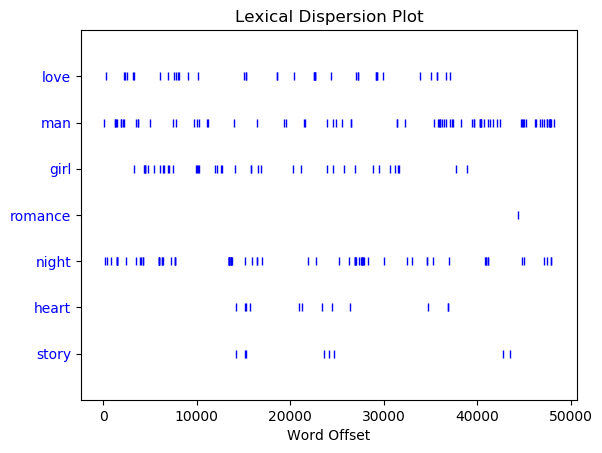

In [71]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['love','man', 'girl', 'romance' ,'night', 'heart', 'story']) #most common words in the romance movie titles
sns.set() #Re-enabling seaborn

In [ ]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

Trying to disperse the words that would be most used for different themes/ genres - Testing it out with the romance genre. I'm still trying to figure out how to compare all the films together as entities as opposed to each film separately or just as a huge compiled text file of all the movie scripts which would be even harder to parse. I think I might separate by each genre and use each genre as the point of analysis first so I have some idea of comparable themes. 

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent than the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [76]:
countsDict = {}
for word in movie_df['Tokenized'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:25]

[('I', 212661),
 ('you', 165982),
 ('the', 144236),
 ('to', 118483),
 ("'s", 104380),
 ('a', 99675),
 ('it', 71414),
 ("n't", 70663),
 ('of', 64662),
 ('that', 60156),
 ('and', 58898),
 ('You', 53911),
 ('do', 52940),
 ('in', 50595),
 ('is', 49109),
 ('me', 47224),
 ('on', 35872),
 ('for', 34283),
 ("'m", 33306),
 ('was', 32809),
 ('have', 32802),
 ('this', 32461),
 ('be', 30647),
 ('know', 30560),
 ('my', 30388)]

In [79]:
word_counts[:300]

[('I', 212661),
 ('you', 165982),
 ('the', 144236),
 ('to', 118483),
 ("'s", 104380),
 ('a', 99675),
 ('it', 71414),
 ("n't", 70663),
 ('of', 64662),
 ('that', 60156),
 ('and', 58898),
 ('You', 53911),
 ('do', 52940),
 ('in', 50595),
 ('is', 49109),
 ('me', 47224),
 ('on', 35872),
 ('for', 34283),
 ("'m", 33306),
 ('was', 32809),
 ('have', 32802),
 ('this', 32461),
 ('be', 30647),
 ('know', 30560),
 ('my', 30388),
 ("'re", 30180),
 ('your', 30018),
 ('we', 29249),
 ('It', 28957),
 ('What', 28357),
 ('not', 27304),
 ('are', 25717),
 ('with', 25029),
 ('what', 23254),
 ('he', 23143),
 ('And', 21667),
 ('here', 21551),
 ('all', 21526),
 ('like', 21342),
 ('just', 20927),
 ("'ll", 20316),
 ('No', 19717),
 ('up', 19528),
 ('We', 19457),
 ('out', 19376),
 ('get', 19105),
 ('right', 18333),
 ('Oh', 18152),
 ('got', 18152),
 ('him', 17624),
 ('go', 17591),
 ('about', 17533),
 ('there', 17226),
 ('He', 16755),
 ('The', 16705),
 ('can', 16593),
 ('That', 16543),
 ('did', 16181),
 ('at', 15815),


The first noun for our cutoff is 'man' so we cutoff the stopwords there

In [99]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'man':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq[:5]

['I', 'you', 'the', 'to', "'s"]

In [85]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

##### Trying to find the most common stem

In [86]:
snowball = SnowballStemmer(language = 'english')


In [87]:
def stemming(words):
    new = []
    stem_words = [snowball.stem(x) for x in (words[:][0])]
    new.append(stem_words)
    return new

In [100]:
stemlist = stemming(movie_df['Tokenized'])

In [101]:
import itertools
stems = list(itertools.chain(*stemlist))


In [105]:
stemcount = wordCounter(stems)

In [106]:
stemcount.sort_values('count', ascending=False, inplace=True)
stemcount[:100]

word  count
6       you    318
63        i    255
88      the    153
70        a    151
22       's    138
..      ...    ...
495     one     13
12   better     13
359    need     12
55       we     12
209    ever     12

[100 rows x 2 columns]

In [ ]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

Now we can create our function to normalize the tokens

In [108]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [227]:
# This took a realllllyyyy long time just in case you want to rerun it.
movie_df['normalized_tokens'] = movie_df['Tokenized'].apply(lambda x: normalizeTokens(x))

movie_df['normalized_tokens_count'] = movie_df['normalized_tokens'].apply(lambda x: len(x))

movie_df.head()

Movie Name                    Genre  Year  \
3435788     Born Reckless  Crime, Drama, Film-Noir  1930   
6880640        Dishonored      Drama, Romance, War  1931   
5482259        Indiscreet   Comedy, Drama, Musical  1931   
5192597  The Stolen Jools            Comedy, Short  1931   
3982760     College Humor                   Comedy  1933   

                          Country     IMDb  \
3435788  English, Italian, French  0020702   
6880640                   English  0021800   
5482259                   English  0022000   
5192597                   English  0022402   
3982760                   English  0023900   

                                                 Tokenized  Word_Counts  \
3435788  [Louis, Louis, Beretti, Shh, Put, that, out, y...         6514   
6880640  [I, thought, I, smelled, gas, That, 's, three,...         3405   
5482259  [Subtitles, Lu, s, Filipe, Bernardes, Wait, Yo...         6247   
5192597  [Subtitles, Lu, s, Filipe, Bernardes, Hello, W...         2180   
3982760  [Play, ball, Although, the, game, seems, uphil...         8856   

                                         normalized_tokens  \
3435788  [louis, louis, beretti, shh, sap, know, well, ...   
6880640  [think, smell, gas, year, decency, leave, gas,...   
5482259  [subtitles, lu, s, filipe, bernarde, wait, nee...   
5192597  [subtitles, lu, s, filipe, bernarde, hello, mu...   
3982760  [play, ball, game, uphill, wo, let, till, play...   

         normalized_tokens_count  
3435788                     2736  
6880640                     1224  
5482259                     2138  
5192597                      862  
3982760                     3485

In [228]:
#Titles tokenized
movie_df['normalized_tokens_titles'] = movie_df['Movie Name'].apply(lambda x: normalizeTokens(x))

movie_df['normalized_tokens_titles_count'] = movie_df['normalized_tokens_titles'].apply(lambda x: len(x))

movie_df.head()

Movie Name                    Genre  Year  \
3435788     Born Reckless  Crime, Drama, Film-Noir  1930   
6880640        Dishonored      Drama, Romance, War  1931   
5482259        Indiscreet   Comedy, Drama, Musical  1931   
5192597  The Stolen Jools            Comedy, Short  1931   
3982760     College Humor                   Comedy  1933   

                          Country     IMDb  \
3435788  English, Italian, French  0020702   
6880640                   English  0021800   
5482259                   English  0022000   
5192597                   English  0022402   
3982760                   English  0023900   

                                                 Tokenized  Word_Counts  \
3435788  [Louis, Louis, Beretti, Shh, Put, that, out, y...         6514   
6880640  [I, thought, I, smelled, gas, That, 's, three,...         3405   
5482259  [Subtitles, Lu, s, Filipe, Bernardes, Wait, Yo...         6247   
5192597  [Subtitles, Lu, s, Filipe, Bernardes, Hello, W...         2180   
3982760  [Play, ball, Although, the, game, seems, uphil...         8856   

                                         normalized_tokens  \
3435788  [louis, louis, beretti, shh, sap, know, well, ...   
6880640  [think, smell, gas, year, decency, leave, gas,...   
5482259  [subtitles, lu, s, filipe, bernarde, wait, nee...   
5192597  [subtitles, lu, s, filipe, bernarde, hello, mu...   
3982760  [play, ball, game, uphill, wo, let, till, play...   

         normalized_tokens_count normalized_tokens_titles  \
3435788                     2736         [bear, reckless]   
6880640                     1224               [dishonor]   
5482259                     2138             [indiscreet]   
5192597                      862            [steal, jool]   
3982760                     3485         [college, humor]   

         normalized_tokens_titles_count  
3435788                               2  
6880640                               1  
5482259                               1  
5192597                               2  
3982760                               2

In [229]:
#Genres tokenized
movie_df['normalized_tokens_genres'] = movie_df['Genre'].apply(lambda x: normalizeTokens(x))

movie_df['normalized_tokens_genres_count'] = movie_df['normalized_tokens_genres'].apply(lambda x: len(x))

movie_df.head()

Movie Name                    Genre  Year  \
3435788     Born Reckless  Crime, Drama, Film-Noir  1930   
6880640        Dishonored      Drama, Romance, War  1931   
5482259        Indiscreet   Comedy, Drama, Musical  1931   
5192597  The Stolen Jools            Comedy, Short  1931   
3982760     College Humor                   Comedy  1933   

                          Country     IMDb  \
3435788  English, Italian, French  0020702   
6880640                   English  0021800   
5482259                   English  0022000   
5192597                   English  0022402   
3982760                   English  0023900   

                                                 Tokenized  Word_Counts  \
3435788  [Louis, Louis, Beretti, Shh, Put, that, out, y...         6514   
6880640  [I, thought, I, smelled, gas, That, 's, three,...         3405   
5482259  [Subtitles, Lu, s, Filipe, Bernardes, Wait, Yo...         6247   
5192597  [Subtitles, Lu, s, Filipe, Bernardes, Hello, W...         2180   
3982760  [Play, ball, Although, the, game, seems, uphil...         8856   

                                         normalized_tokens  \
3435788  [louis, louis, beretti, shh, sap, know, well, ...   
6880640  [think, smell, gas, year, decency, leave, gas,...   
5482259  [subtitles, lu, s, filipe, bernarde, wait, nee...   
5192597  [subtitles, lu, s, filipe, bernarde, hello, mu...   
3982760  [play, ball, game, uphill, wo, let, till, play...   

         normalized_tokens_count normalized_tokens_titles  \
3435788                     2736         [bear, reckless]   
6880640                     1224               [dishonor]   
5482259                     2138             [indiscreet]   
5192597                      862            [steal, jool]   
3982760                     3485         [college, humor]   

         normalized_tokens_titles_count    normalized_tokens_genres  \
3435788                               2  [crime, drama, film, noir]   
6880640                               1       [drama, romance, war]   
5482259                               1    [comedy, drama, musical]   
5192597                               2             [comedy, short]   
3982760                               2                    [comedy]   

         normalized_tokens_genres_count  
3435788                               4  
6880640                               3  
5482259                               3  
5192597                               2  
3982760                               1

### Lemmatization

In [110]:
#.sum() adds together the lists from each row into a single list
movie_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in movie_df['normalized_tokens'].sum()))

#print the number of words
print(movie_cfdist.N())

2207580


###### Length

From this we can lookup the distributions of different word lengths

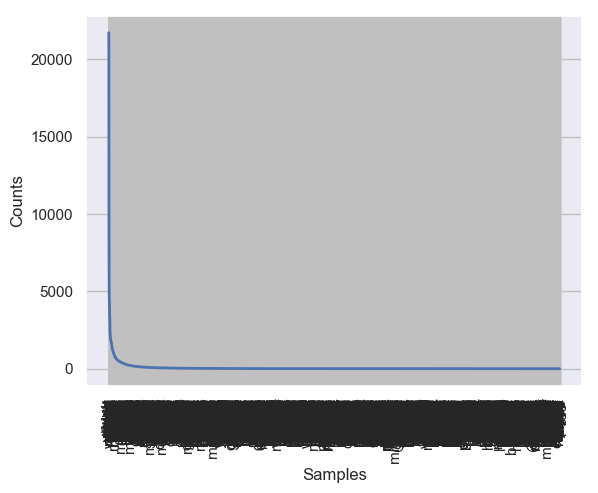

In [156]:
movie_cfdist[5].plot()

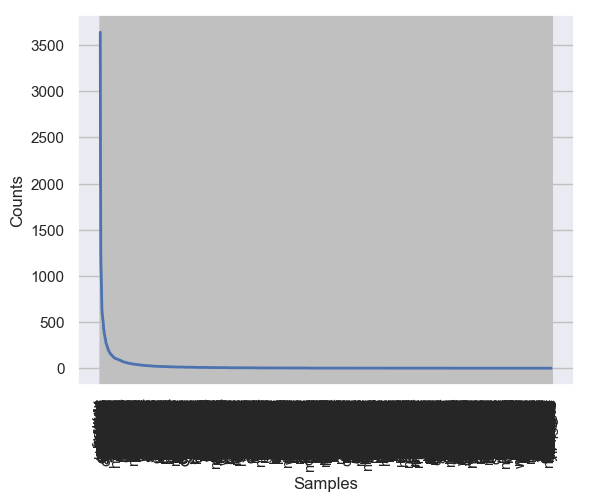

In [157]:
movie_cfdist[7].plot()

In [113]:
movie_cpdist = nltk.ConditionalProbDist(movie_cfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(movie_cpdist[2].max())

#And its probability
print(movie_cpdist[2].prob(movie_cpdist[2].max()))

oh
0.17807671699737368


In [158]:
movie_cpdist = nltk.ConditionalProbDist(movie_cfdist, nltk.ELEProbDist)

#print the most common 3 letter word
print(movie_cpdist[3].max())

#And its probability
print(movie_cpdist[3].prob(movie_cpdist[3].max()))

get
0.07435685486171911


In [159]:
movie_cpdist = nltk.ConditionalProbDist(movie_cfdist, nltk.ELEProbDist)

#print the most common 7 letter word
print(movie_cpdist[7].max())

#And its probability
print(movie_cpdist[7].prob(movie_cpdist[7].max()))

believe
0.02122541100723746


In [160]:
movie_cpdist = nltk.ConditionalProbDist(movie_cfdist, nltk.ELEProbDist)

#print the most common 9 letter word
print(movie_cpdist[9].max())

#And its probability
print(movie_cpdist[9].prob(movie_cpdist[9].max()))

everybody
0.02804179659390741


##### POS

In [114]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [230]:
movie_df['normalized_tokens_POS_title'] = [spacy_pos(t) for t in movie_df['Movie Name']] #Running it on movie names to see associations there, 
#when I rerun this will do it with the original clean raw text, which is not in this dataframe so will add it when I rerun it
#- Cannot run it on the tokenized text

In [122]:
movie_cfdist_WordtoPOS = nltk.ConditionalFreqDist(movie_df['normalized_tokens_POS_title'].sum())
list(movie_cfdist_WordtoPOS.items())[:10]

[('born', FreqDist({'VBN': 2})),
 ('reckless', FreqDist({'JJ': 1})),
 ('dishonored', FreqDist({'VBN': 1})),
 ('indiscreet', FreqDist({'NNP': 1})),
 ('the', FreqDist({'DT': 270})),
 ('stolen', FreqDist({'VBN': 1})),
 ('jools', FreqDist({'NNS': 1})),
 ('college', FreqDist({'NN': 1})),
 ('humor', FreqDist({'NN': 1})),
 ('man', FreqDist({'NN': 13, 'NNP': 2}))]

#### Parts of Speech Stuff

In [127]:
movie_cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in movie_df['normalized_tokens_POS_title'].sum())

We can now identify and collect all of the superlative adjectives

In [128]:
movie_cfdist_POStoWord['JJ']

FreqDist({'last': 9, 'dark': 5, 'dead': 4, 'final': 4, 'secret': 3, 'mad': 3, 'little': 3, 'high': 3, 'new': 3, 'black': 3, ...})

In [162]:
movie_cfdist_POStoWord['JJ'].most_common(5)

[('last', 9), ('dark', 5), ('dead', 4), ('final', 4), ('secret', 3)]

Interesting how almost all of the superlatives are sinister

In [129]:
movie_cfdist_POStoWord['NN'].most_common(5)

[('man', 13), ('life', 11), ('night', 7), ('story', 7), ('love', 6)]

The most common nouns make a lot of sense weirdly.

Or plot the base form verbs against their number of occurrences

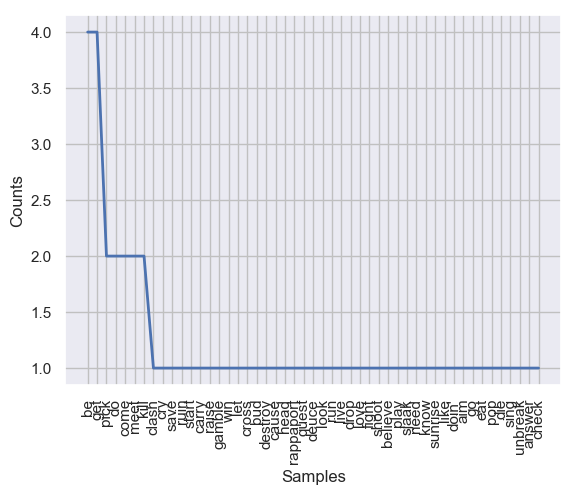

In [130]:
movie_cfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [131]:
movie_cpdist_POStoWord = nltk.ConditionalProbDist(movie_cfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(movie_cpdist_POStoWord['NN'].max())

#And its probability
print(movie_cpdist_POStoWord['NN'].prob(movie_cpdist_POStoWord['NN'].max()))

man
0.017153748411689963


In [152]:
movie_cpdist_POStoWord = nltk.ConditionalProbDist(movie_cfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(movie_cpdist_POStoWord['NNS'].max())

#And its probability
print(movie_cpdist_POStoWord['NNS'].prob(movie_cpdist_POStoWord['NNS'].max()))

men
0.029345372460496615


In [163]:
movie_cpdist_POStoWord = nltk.ConditionalProbDist(movie_cfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(movie_cpdist_POStoWord['JJ'].max())

#And its probability
print(movie_cpdist_POStoWord['JJ'].prob(movie_cpdist_POStoWord['JJ'].max()))

last
0.041758241758241756


### Word cloud for Text of Scripts

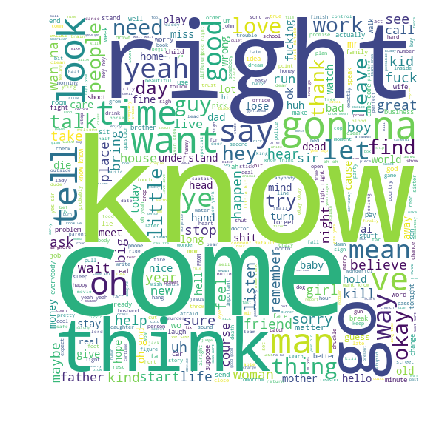

In [133]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("text_word_cloud.pdf", format = 'pdf')

### Word cloud for Movie Names

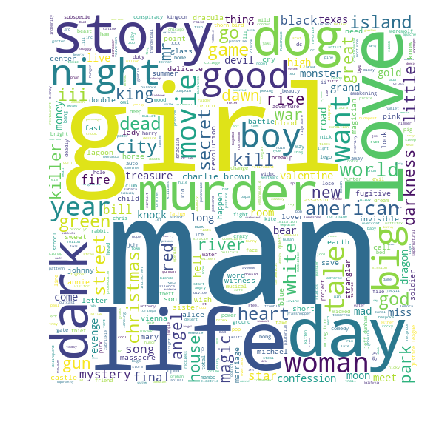

In [147]:
wc2 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df['normalized_tokens_titles'].sum()))
plt.imshow(wc2)
plt.axis("off")
plt.savefig("moviename_word_cloud.pdf", format = 'pdf')

Interesting how the most common words are man and girl, might be indicative of how women are always written in a more infantile manner compared to the more adult, manly man. Seems plausible that theme wise, love, dark, murder and life are also common words - this seems indicative of common theme/ genre that is included in all the different genres. For example, a romance movie can have elements of dark-ness and is a part of life, idk. Would need to delve deeper by genre and potentially decades to see what themes were common over different time periods?

### Word cloud for Movie Genres

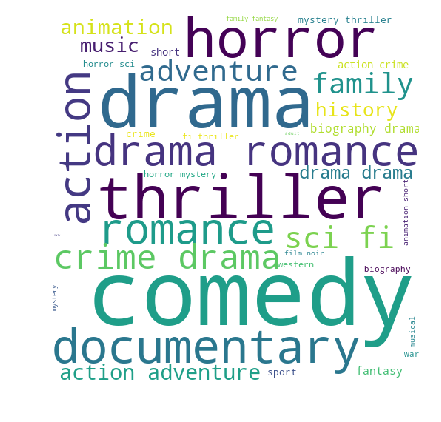

In [149]:

wc3 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(movie_df['normalized_tokens_genres'].sum()))
plt.imshow(wc3)
plt.axis("off")
plt.savefig("moviegenre_word_cloud.pdf", format = 'pdf')

This will probably be more informative when I merge the movie revenue information and imdb scores probably to see which genres are most lucrative and yield higher imdb scores.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [ ]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [ ]:
movie_texts = {}

In [ ]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [ ]:
import pandas as pd

In [ ]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [ ]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [ ]:
movie_df.head()

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [164]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [165]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [166]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [292]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [168]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, ,, Help, Desk, got, a, call, fro...  
8  [[First, post, in, quite, some, time, !], [I, ...  
7  [[[, Original, Post, ], (, https, :, //www.red...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened, ...], [So, ,, I, had, ...  
3  [[Another, tale, from, the, out, of, hours], [...  
2  [[[, Part, 1, ], (, http, :, //www.reddit.com/...  
1  [[>], [$, Me], [-, Hello, ,, IT, .], [>, $], [...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [169]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [170]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [171]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NNP),...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[([, -LRB-), (Original, JJ), (Post, NNP), (],...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, -LRB-), (Part, NN), (1, CD), (], -RRB-),...
1    [[(>, XX), ($, $)], [(Me, NNP), (-, HYPH), (He...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [172]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('m', 17),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('Genius', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('Boss', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the adjectives that modify the word, "computer"?

In [173]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

I am going to subset just the Western only movie genres and examine their parts of speech and see the associations there. After I make the dummies of all the genres like in hw 0, I'll include all those Western films that also are other genres. But for now, I'm just going to look at only Western movies. - I tried a Western only subset and a by year only subset, eg. only 1970 but since the limit is set was only 500, there weren't too many cases so used the entire new 500 piece dataset cause it was very slow running it with all the scripts

In [250]:
movie_texts2 = {}

In [251]:
for files in movie_raw:
    if len(movie_texts2) > 500:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        try:
            movie_texts2[movie[2:8]] = movie[1:]
        except IndexError:
            continue

In [242]:
movie_df2 = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Text"])

In [293]:
movie_df2['sentences'] = movie_df2['Text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])


In [253]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df2.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts2[fileid.strip()]]
    except KeyError:
        continue

In [295]:
movie_df2.head()

Movie Name                            Genre  \
186740                The Green Pastures                            Drama   
103977                 The Invisible Ray         Horror, Sci-Fi, Thriller   
209763                        The Letter          Crime, Drama, Film-Noir   
207254       Witness for the Prosecution  Crime, Drama, Mystery, Thriller   
193201  Where Angels Go Trouble Follows!                           Comedy   

        Year          Country  \
186740  1936          English   
103977  1936  English, French   
209763  1940          English   
207254  1957  English, German   
193201  1968          English   

                                                     Text  \
186740  @186740 Here , you can look at it . - Why does...   
103977  @103977 [Thunder_clapping] [Thunder_rumbling] ...   
209763  @209763 Come inside . Do you know where the ne...   
207254  @207254 Silence . Be upstanding in court . All...   
193201  @193201 Not a single arrest today , Mother . D...   

                                                sentences  
186740  [[@, 186740], [Here, ,, you, can, look, at, it...  
103977  [[@, 103977, [, Thunder_clapping, ]], [[, Thun...  
209763  [[@, 209763, Come, inside, .], [Do, you, know,...  
207254  [[@, 207254, Silence, .], [Be, upstanding, in,...  
193201  [[@, 193201, Not, a, single, arrest, today, ,,...

In [269]:
#is_1970_only =  movie_df2['Year']=="1970"
#only_1970 = movie_df2[is_1970_only]

In [276]:
#only_1970.head()

Movie Name                    Genre  Year           Country  \
150071         Rio Lobo  Adventure, Romance, War  1970  English, Spanish   
129725  Zabriskie Point                    Drama  1970           English   

                                                     Text  \
150071  @150071 ( Rhythmictapping ) ( Acousticguitarpl...   
129725  @129725 It's always the same story , it's been...   

                                                POS_sents  
150071  [[(@, NNP), (1, CD), (5, CD), (0, CD), (0, CD)...  
129725  [[(@, NNP), (1, CD), (2, CD), (9, CD), (7, CD)...

In [296]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [298]:
movie_df2['POS_sents'] = movie_df2['sentences'].apply(lambda x: tag_sents_pos(x))

In [299]:
countTarget = 'NN'
targetCounts = {}
for entry in movie_df2['POS_sents'] :
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 2031),
 ('man', 885),
 ('time', 772),
 ('way', 530),
 ('something', 461),
 ('thing', 374),
 ('one', 372),
 ('night', 333),
 ('sir', 321),
 ('day', 308),
 ('anything', 304),
 ('@', 269),
 ('#', 263),
 ('money', 262),
 ('girl', 255),
 ('life', 255),
 ('name', 253),
 ('place', 252),
 ('car', 245),
 ('nothing', 242)]

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [289]:
movie_Bigrams = nltk.collocations.BigramCollocationFinder.from_words(movie_df['normalized_tokens'].sum())

In [278]:
print("There are {} bigrams in the finder".format(movie_Bigrams.N))

There are 2207580 bigrams in the finder


In [279]:
def bigramScoring(count, wordsTuple, total):
    return count

print(movie_Bigrams.nbest(bigramScoring, 10))

[('gon', 'na'), ('ve', 'get'), ('m', 'sorry'), ('m', 'gon'), ('wan', 'na'), ('get', 'ta'), ('m', 'go'), ('oh', 'god'), ('look', 'like'), ('come', 'come')]


In [280]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

movie_Bigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  195, The second word is: 195
The first word is:  195, The second word is: 22
The first word is:  22, The second word is: 465
The first word is:  465, The second word is: 20
The first word is:  20, The second word is: 36102
The first word is:  36102, The second word is: 2169
The first word is:  2169, The second word is: 9531
The first word is:  9531, The second word is: 57
The first word is:  57, The second word is: 5665
The first word is:  5665, The second word is: 719


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [281]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
movie_Bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('gon', 'na'), 122402.30306368682),
 (('wan', 'na'), 27490.424983716475),
 (('m', 'sorry'), 21940.850863828462),
 (('get', 'ta'), 19193.436630585915),
 (('ve', 'get'), 17886.130785705034),
 (('0,0:00:00.00,0:00:00.00', 'default'), 14672.888649518669),
 (('comment', '0,0:00:00.00,0:00:00.00'), 14070.122892280986),
 (('m', 'gon'), 13130.176098204949),
 (('oh', 'god'), 12611.037409327106),
 (('new', 'york'), 8613.25871434304),
 (('ha', 'ha'), 7755.705600126691),
 (('look', 'like'), 6297.004826992314),
 (('yes', 'sir'), 5960.37038040846),
 (('m', 'go'), 5957.440503714426),
 (('little', 'bit'), 5824.350921488255),
 (('year', 'ago'), 5361.2760904651905),
 (('wait', 'minute'), 4998.582184192321),
 (('la', 'la'), 4933.643147518683),
 (('hey', 'hey'), 4918.037145441998),
 (('mm', 'hmm'), 4563.980093507396),
 (('m', 'sure'), 4211.225194966719),
 (('ve', 'see'), 3947.1741708468367),
 (('da', 'da'), 3940.7913326441444),
 (('whoa', 'whoa'), 3933.0114267837143),
 (('yeah', 'yeah'), 3695.9265227121

There are a lot of colloquialisms and a lot of salutations

In [282]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [283]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
movie_Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(movie_df['normalized_tokens'].sum())
movie_Trigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('m', 'gon', 'na'), 55.44231293150731),
 (('comment', '0,0:00:00.00,0:00:00.00', 'default'), 28.844405167206215),
 (('m', 'sorry', 'm'), 18.489515223711795),
 (('hey', 'hey', 'hey'), 18.29329877483687),
 (('think', 'gon', 'na'), 16.392437523488205),
 (('ha', 'ha', 'ha'), 16.27879876009478),
 (('la', 'la', 'la'), 16.248072458972104),
 (('come', 'come', 'come'), 16.132154925614994),
 (('know', 'gon', 'na'), 16.055254871894654),
 (('ai', 'gon', 'na'), 15.614910740407758),
 (('gon', 'na', 'kill'), 15.384984352376707),
 (('ve', 'get', 'ta'), 14.986922178121008),
 (('sorry', 'm', 'sorry'), 14.745383117166169),
 (('yeah', 'yeah', 'yeah'), 14.584034302645735),
 (('oh', 'god', 'oh'), 14.559449946583065),
 (('wait', 'wait', 'wait'), 14.52309566256092),
 (('da', 'da', 'da'), 14.212668756464554),
 (('gon', 'na', 'tell'), 13.89743696332581),
 (('okay', 'okay', 'okay'), 13.868372862519216),
 (('oh', 'oh', 'oh'), 13.43861884790466)]

Here also, we see that the trigrams show colloquialisms.

In [284]:
Ngrams = nltk.ngrams(movie_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('oh', 'yeah', 'mm', 'hmm'): 5, ('better', 'm', 'gon', 'na'): 4, ('huh', 'ai', 'gon', 'na'): 3, ('like', 'ai', 'gon', 'na'): 2, ('ai', 'gon', 'na', 'happen'): 7, ('hello', 'louis', 'hello', 'good'): 2, ('louis', 'hello', 'good', 'news'): 2, ('gon', 'na', 'little', 'walk'): 2, ('listen', 'm', 'gon', 'na'): 19, ('m', 'gon', 'na', 'great'): 3, ('gon', 'na', 'great', 'big'): 2, ('m', 'gon', 'na', 'guy'): 8, ('m', 'gon', 'na', 'gun'): 3, ('hey', 'sarge', 'guy', 'lookin'): 3, ('sarge', 'guy', 'lookin', 'hey'): 3, ('guy', 'lookin', 'hey', 'sarge'): 2, ('lookin', 'hey', 'sarge', 'guy'): 2, ('hut', 'hut', 'hut', 'oh'): 2, ('come', 'come', 'yeah', 'come'): 3, ('hey', 'come', 'come', 'come'): 9, ('come', 'come', 'come', 'come'): 66, ('come', 'come', 'come', 'oh'): 7, ('hey', 'wait', 'minute', 'wait'): 4, ('wait', 'minute', 'wait', 'minute'): 49, ('wan', 'na', 'lose', 'love'): 2, ('kill', 'family', 'gon', 'na'): 2, ('family', 'gon', 'na', 'let'): 2, ('gon', 'na', 'let', 'away'): 7, ('let', 'away'

5 scripts seem to have a 4 word collocation of 'Oh yeah, mmhmm', another colloquialism. I might need to remove or add to stopwords.

In [285]:
import gensim

In [286]:
bigram = gensim.models.Phrases(movie_df['normalized_tokens'])

In [287]:
texts = [bigram[line] for line in movie_df['normalized_tokens']]

In [288]:
texts[0]

['louis',
 'louis_beretti',
 'shh',
 'sap',
 'know',
 'well',
 'hey',
 'hack',
 'sure',
 'joe',
 'fleischer',
 'fleischer',
 'yeah',
 'cassidy',
 'look',
 'uh',
 'taxicab',
 'hustle',
 'let',
 'let',
 'big',
 'everybody',
 'okay',
 'okay',
 'big',
 'hit_hit',
 'right',
 'joe',
 'step',
 'elevated',
 'quick',
 'come',
 'right',
 'louis',
 'louis',
 'trick',
 'sal',
 'oh',
 'tough',
 'yeah',
 'figure',
 'usin',
 'dishwater',
 'soup',
 'tonight',
 'yeah',
 'buck',
 'ham',
 'egg',
 'eat',
 'ham',
 'yeah',
 'right',
 'oh',
 'thanks',
 'right',
 'sure',
 'look',
 'swell',
 'makeup',
 'yeah',
 'regular',
 'working',
 'guy',
 'aw',
 'sock',
 'jaw',
 'wan_na',
 'work',
 'dumb',
 'guy',
 'babe',
 'right',
 'swell',
 'long',
 'hello',
 'mom',
 'luigi',
 'hello',
 'pop',
 'ya',
 'right',
 'mom',
 'huh',
 'work_hard',
 'boy',
 'sit',
 'yeah',
 'yeah',
 'boss',
 'think',
 'truck_driver',
 'ai',
 'get',
 'home',
 'late',
 'delivery',
 'greenpoint',
 'old',
 'spaghetti',
 'work',
 'boss',
 'yeah',
 'd

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

For only finding ents-

In [427]:
sent = nlp(str(movie_df2['Text']))

In [428]:
for token in sent:
    print(token.text, token.ent_type_)

186740 DATE
    
@186740 PERSON
Here 
, 
you 
can 
look 
at 
it 
. 
- 
Why 
does 
... 

 
103977 DATE
    
@103977 
[ 
Thunder_clapping 
] 
[ 
Thunder_rumbling 
] 
... 

 
209763 DATE
    
@209763 LOC
Come 
inside 
. 
Do 
you 
know 
where 
the 
ne 
... 

 
207254 DATE
    
@207254 
Silence 
. 
Be 
upstanding 
in 
court 
. 
All 
... 

 
193201 DATE
    
@193201 
Not 
a 
single 
arrest 
today DATE
, 
Mother 
. 
D 
... 

 
150071 DATE
    
@150071 
( 
Rhythmictapping 
) 
( 
Acousticguitarpl GPE
... 

 
129725 DATE
    
@129725 
It 
's 
always 
the 
same 
story 
, 
it 
's 
been 
... 

 
151019 DATE
    
@151019 PRODUCT
Hurry PRODUCT
and 
get 
him 
outta 
there 
! 
I 
need 
... 

 
191062 DATE
    
@191062 
The 
State 
accuses 
my 
client 
of 
violati 
... 

 
145798 DATE
    
@145798 
Just 
remember 
. 
Do 
n't 
swear 
... 
when 
y 
... 

 
204718 DATE
    
@204718 
? 
And 
when 
I 
die 
? 
? 
Wo 
n't 
you 
bury 
me 
... 

 
102865 DATE
    
@102865 
Investment 
: 
Lee PERSON
Project PERSO

In [429]:
for ent in sent.ents:
    print(ent.text, ent.label_)

186740 DATE
@186740 PERSON
103977 DATE
209763 DATE
@209763 LOC
207254 DATE
193201 DATE
today DATE
150071 DATE
Acousticguitarpl GPE
129725 DATE
151019 DATE
@151019 Hurry PRODUCT
191062 DATE
145798 DATE
204718 DATE
102865 DATE
Lee Project PERSON
101202 DATE
157953 DATE
144697 DATE
128173 DATE
156465 DATE
Chris PERSON
175361 DATE
DAIEI CO INC ORG
100514 DATE
111573 DATE
Aargh PERSON
210226 DATE
217931 DATE
COMPANY LTD ORG
SHIKENBARU S PRODUCT
192421 DATE
204372 DATE
174378 DATE
tende GPE
226262 DATE
Children] WORK_OF_ART
151927 DATE
225158 DATE
192384 DATE
@192384 PRODUCT
204812 CARDINAL
Hawaii GPE
214225 DATE
SEOUL GPE
KOREA 1992 ORG
NEW YORK CITY GPE
1998 DATE
106637 DATE
@106637 Good WORK_OF_ART
106274 DATE
111596 DATE
gu GPE
216006 DATE
206314 DATE
143722 DATE
@143722 GPE
103940 DATE
@103940 Doc PRODUCT
111964 DATE
132253 DATE
last night TIME
196094 DATE
Burt Reynolds PERSON
111950 DATE
Rodgers WORK_OF_ART
200308 DATE
195269 DATE
Dot Lancaster PERSON
110666 DATE
@110666 Listen WORK_OF

In [300]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [302]:
movie_df2['classified_sents'] = movie_df2['sentences'].apply(lambda x: tag_sents_ner(x))

Find the most common entities (which are, of course, boring):

In [303]:
entityCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('one', 347),
 ('two', 285),
 ('first', 235),
 ('today', 169),
 ('tonight', 153),
 ('One', 140),
 ('three', 126),
 ('tomorrow', 96),
 ('Lawd', 94),
 ('Chris', 86)]

Or those occurring only twice:

In [304]:
[x[0] for x in sortedEntities if x[1] == 2]

['Viney',
 'Carlotta',
 'Myrtle',
 'Genesis',
 'Dubois',
 'Abel',
 'Sixth',
 'four bits',
 'Shem',
 'Japheth',
 'Isaac',
 'Sun',
 'the Land of Egypt',
 'David',
 'Hosea',
 'Francis Stevens',
 'Ronald Drake',
 'Lady Stevens',
 'many years ago',
 'three years ago',
 'a million',
 'One milligram',
 '0',
 'Safari',
 'Astro',
 'Briggs',
 'Lemaire',
 'Reno',
 'Lower Crossway',
 'Fred',
 'About an hour',
 'several weeks',
 'Reed',
 'Crosbie',
 '1 0 years',
 'Jerry',
 'all evening',
 'Chung',
 'Liverpool',
 'a thousand',
 'European',
 '$ 1 0,000',
 'about a year ago',
 "a good night 's",
 '37 years',
 '1952',
 '- Electric',
 '9.26',
 'Inspector',
 'Scotland Yard',
 'de luxe',
 'Russian',
 '` Mr Vole',
 'Hamburg',
 'Fraulein',
 'Thermos',
 '1 30',
 'Richard',
 'One week',
 'the night of October 14',
 "Leonard Vole 's",
 'Lover',
 'the National Health Insurance',
 '25 minutes past 9',
 'Helm',
 'Frau Helm',
 'ten past ten',
 'Good evening',
 'the afternoon',
 'Sullivan',
 'Swindon',
 'every minu

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [305]:
nonObjCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('one', 347),
 ('two', 285),
 ('first', 235),
 ('today', 169),
 ('tonight', 153),
 ('One', 140),
 ('three', 126),
 ('tomorrow', 96),
 ('Chris', 86),
 ('second', 83)]

What about the Organizations?

In [306]:
OrgCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Grandpappy
De Lawd
De Lawd
De Lawd
Lawd
Lawd Certainly
Lawd
Lawd
Lawd Certainly
Lawd
Lawd
Lawd Certainly
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
the Pearly Gates
Lawd
Lawd
Lawd
Lawd
De @ @ @ @ @ @ @ @
Seth
Lawd
Lawd
Freeport
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
De Lawd
De Lawd
De Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
TOOLONG
TOOLONG
Lawd @ @
Lawd
Lawd
Lawd
Lawd
De Lawd 's
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Hebrews
Hebrews
the Land of Egypt
De Lawd
De Lawd
the Land of Egypt
De Lawd
Lawd
De Lawd
Lawd
Lawd
De Lawd
De Lawd
Lawd
Lawd
Lawd
Lawd
Babylon
Sodom
Lawd
De Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Lawd
Hezdrel
Hezdrel
Hezdrel
Hezdrel
De Lawd
Lawd
Lawd
De Lawd
Lawd
Hezdrel
Lawd
Lawd
Lawd
Lawd
Lawd
Thundering_continues
MotherRukh
Janos
Janos
the University of Paris
Andromeda
Andromeda
Janos
TOOLONG
TOOLONG Choco
Janos
the International Scientific Congress
the Paris Herald
the New York Herald
the Medical Examiner
Janos
Congress
the University

Venusian
Nike
Nike
Nike
Nick
Nick
Nick
Nick_Knocking_At_Door
Nick ] Marshall
Nike
Nike
Erin
Nike
Nike
Nike
Nike
Nike
Annie
Erin
Erin
Nike
Nick
the Beastie Boys
Ferrari
Woodman
Woodman
The Beastie Boys
Jell-O
Chris @ @ @
the Chris Campbell Nail
The Nail and Bail
Cosmo
Gladstone hotel
Micah
Rowdy Virago
Paramount
FBI
Merrill Candide
Micah
Micah
Micah
Paramount
Micah
Paramount
Rowdy Virago
Rowdy Virago
Merrill Candide
FBI
Finch
Burt Reynold 's
MGM
TOOLONG
Gladstone
Rowdy Virago
@ @ @ @ @ @ @ @
Union Station
Paramount
NOS
NOS
NOS
NIRA
NOS
NOS
NOS
Tucson
Honda
NOS
FBI
FBI
Harry 's
Harry 's
Spirit
Hector
Honda
NOS
Nissan SR20
psi
Bilkins @ @
Ferrari
Jetta
Honda
SWAT
Letty
PD
GRACE
GRACE @ @ @ @
Christ
ANNE
ROMANS
Christ
ROMANS
Hells
GRACE
GRACE
GRACE
GRACE
Louder_thumps_overhead
GRACE
First Communion
Charles @ @ @ @ @ @ @
GRACE
GRACE
GRACE
GRACE
Clay
Clay
Shoot
Cupid
Y'all
Jumbo Jimbo 's
Ronwell Quincy Dobbs
Duke
Everything 's @ @ @ @ @ @ @ @ @
Daffy Mal Yinkle-Yankle
Hummers
Fuzz
Time
Elimi

In [431]:
EventCounts = {}
for entry in movie_df2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'EVENT':
                print(ent)

Old King Pharaoh
Old King Pharaoh 's
the @ @ @ @ @ @ @ @ @ @
Old King Pharaoh
Old King Pharaoh
@ @ @ @ @ @ @ @
the @ @ @ @ @ @ @ @ @ @
the Chinese Quarter
@ @
The Crimean War
the @ @ @ @ @ @ @ @ @ @
@ @ @ @ @ @ @ @ @ @
the @ @ @ @ @ @ @ @ @
@ @ @ @ @ @ @
the @ @
the @ @ @ @ @ @ @ @ @ @
the @ @ @
the @ @ @ @ @ @ @ @
the Little Red Book
The @ @ @ @ @ @ @
the @ @ @ @ @ @ @ @ @ @
the @ @
the @ @ @ @ @ @ @ @ @ @ You shout `` national security
Black Congress
Black Congress
@ @ @ @ @ @ @
@ @ @ @ @ @ @ @ @
@ @ @ @ @ @ @ @ @
The Delta Chis
@ @
the @ @
No @ @ @ @ @ @ @ @ @
this @ @ @ @ @ @ @ @ @ @
the Nineties Givin '
the @ @ @ @ @ @ @ @ @ @
@ @ Resistance
@ @ @ @ @ @ @ @ @ @
the @ @
@ @ @ @ @ @ @ @ @ @
New Year 's Eve
New Year 's Eve
the New Year
New Year
New Years
New Year
New Year 's Eve
New Year 's Eve
@ @ @ @ @ @ @ @ @ @
the Vietnam War
Civil War
@ @ @ @ @ @ @ @ @ @
the @ @ @ @ @ @ @ @ @ @
the @ @ @ @ @ @ @ @ @
@ @ @ @ @ @ @ @ @ @
@ @ @ @ @ @
this @ @ @ @ @ @ @ @ @ @
the Euro Larvae River
t

These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [307]:
from spacy import displacy

In [313]:
movie_df2.head()

Movie Name                            Genre  \
186740                The Green Pastures                            Drama   
103977                 The Invisible Ray         Horror, Sci-Fi, Thriller   
209763                        The Letter          Crime, Drama, Film-Noir   
207254       Witness for the Prosecution  Crime, Drama, Mystery, Thriller   
193201  Where Angels Go Trouble Follows!                           Comedy   

        Year          Country  \
186740  1936          English   
103977  1936  English, French   
209763  1940          English   
207254  1957  English, German   
193201  1968          English   

                                                     Text  \
186740  @186740 Here , you can look at it . - Why does...   
103977  @103977 [Thunder_clapping] [Thunder_rumbling] ...   
209763  @209763 Come inside . Do you know where the ne...   
207254  @207254 Silence . Be upstanding in court . All...   
193201  @193201 Not a single arrest today , Mother . D...   

                                                sentences  \
186740  [[@, 186740], [Here, ,, you, can, look, at, it...   
103977  [[@, 103977, [, Thunder_clapping, ]], [[, Thun...   
209763  [[@, 209763, Come, inside, .], [Do, you, know,...   
207254  [[@, 207254, Silence, .], [Be, upstanding, in,...   
193201  [[@, 193201, Not, a, single, arrest, today, ,,...   

                                                POS_sents  \
186740  [[(@, IN), (186740, CD)], [(Here, RB), (,, ,),...   
103977  [[(@, IN), (103977, CD)], [([, -LRB-), (Thunde...   
209763  [[(@, IN), (209763, CD), (Come, VB), (inside, ...   
207254  [[(@, IN)], [(207254, CD), (Silence, NNP), (.,...   
193201  [[(@, IN), (193201, CD), (Not, RB), (a, DT), (...   

                                         classified_sents  
186740  [[(186740, DATE)], [], [], [], [], [], [], [],...  
103977  [[(103977, DATE)], [], [], [(Thundering_contin...  
209763  [[(209763, DATE)], [], [], [], [], [(Hammond, ...  
207254  [[], [], [], [(the Central Criminal Court, ORG...  
193201  [[(193201, DATE), (today, DATE)], [], [], [], ...

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [315]:
doc = nlp(str(movie_df2['Text']))

In [316]:
displacy.render(doc, style='dep')

In [317]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

@186740 @186740 ROOT @186740
you you nsubj look
it it pobj at
Thunder_clapping Thunder_clapping appos @103977
[Thunder_rumbling Thunder_rumbling ROOT Thunder_rumbling
@209763 @209763 nsubj Come
you you nsubj know
@207254 Silence Silence ROOT Silence
court court pobj in
Not a single arrest arrest dobj @193201
D D ROOT D
Rhythmictapping Rhythmictapping appos @150071
Acousticguitarpl Acousticguitarpl appos @150071
It It nsubj 's
the same story story attr 's
it it nsubjpass been
him him nsubj outta
I I nsubj need
The State State nsubj accuses
my client client dobj accuses
violati violati pobj of
when y y ROOT y
204718    @204718 @204718 ROOT @204718
I I nsubj die
you you nsubj bury
me me dobj bury
102865    @102865 Investment Investment ROOT Investment
Lee Project Project appos Investment
Distribution/ Distribution/ appos Project
101202    @101202 @101202 ROOT @101202
@crowd_cheering @crowd_cheering appos @101202
( commentator commentator ROOT commentator
It It ROOT It
@knock_at_door @knoc

spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [318]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

186740 ROOT 186740 NUM [   ]
     186740 NUM []
@186740 ROOT @186740 PROPN []
Here advmod look VERB []
, punct look VERB []
you nsubj look VERB []
can aux look VERB []
look ROOT look VERB [Here, ,, you, can, at, .]
at prep look VERB [it]
it pobj at ADP []
. punct look VERB []
- ROOT - PUNCT []
Why advmod does AUX []
does ROOT does AUX [Why, ...]
... punct does AUX [
]

  ... PUNCT []
103977 ROOT 103977 NUM [   , @103977]
     103977 NUM []
@103977 prep 103977 NUM [[, Thunder_clapping, ]]
[ punct @103977 PROPN []
Thunder_clapping appos @103977 PROPN []
] punct @103977 PROPN []
[ punct Thunder_rumbling NOUN []
Thunder_rumbling ROOT Thunder_rumbling NOUN [[, ], ...]
] punct Thunder_rumbling NOUN []
... punct Thunder_rumbling NOUN [
]

  ... PUNCT []
209763 ROOT 209763 NUM [   ]
     209763 NUM []
@209763 nsubj Come VERB []
Come ROOT Come VERB [@209763, inside, .]
inside advmod Come VERB []
. punct Come VERB []
Do aux know VERB []
you nsubj know VERB []
know ROOT know VERB [Do, you, where]

I nsubj saw VERB []
saw ROOT saw VERB [@204372, I, ..., something, ...]
... punct saw VERB []
something dobj saw VERB [nasty, in]
nasty amod something PRON []
in prep something PRON [woods]
the det woods NOUN []
woods pobj in ADP [the]
... punct saw VERB [
]

  ... PUNCT []
174378 ROOT 174378 NUM [   ]
     174378 NUM []
@174378 ROOT @174378 ADP []
Sometimes advmod speaks VERB []
he nsubj speaks VERB []
speaks ROOT speaks VERB [Sometimes, he, in, ...]
in prep speaks VERB [kind]
a det kind NOUN []
kind pobj in ADP [a, of]
of prep kind NOUN [tende]
tende pobj of ADP []
... punct speaks VERB [
]

  ... PUNCT []
226262 nummod @226262 NOUN [   ]
     226262 NUM []
@226262 ROOT @226262 NOUN [226262]
[ punct Children PROPN []
Children ROOT Children PROPN [[, ]]
] punct Children PROPN []
Should aux be AUX []
auld aux be AUX []
acquaintance nsubj be AUX []
be ROOT be AUX [Should, auld, acquaintance, ...]
... punct be AUX [
]

  ... PUNCT []
151927 ROOT 151927 NUM [   ]
     151927 NUM []
@15192

105081 nummod Stuart PROPN [   ]
     105081 NUM []
@105081 compound Stuart PROPN []
Stuart npadvmod are AUX [105081, @105081]
, punct are AUX []
are ROOT are AUX [Stuart, ,, you, there, ?]
you nsubj are AUX []
down advmod there ADV []
there advmod are AUX [down]
? punct are AUX []
Yeah ROOT Yeah INTJ [,, M, ...]
, punct Yeah INTJ []
M npadvmod Yeah INTJ []
... punct Yeah INTJ [
]

  ... PUNCT []
239257 nummod Dahlia PROPN [   ]
     239257 NUM []
@239257 compound Dahlia PROPN []
Dahlia npadvmod let VERB [239257, @239257]
, punct let VERB []
let ROOT let VERB [Dahlia, ,, go, .]
's nsubj go VERB []
go ccomp let VERB ['s, inside, now]
inside advmod go VERB []
now advmod go VERB []
. punct let VERB []
She nsubj 'll VERB []
'll ROOT 'll VERB [She, ...]
... punct 'll VERB [
]

  ... PUNCT []
240664 nummod @240664 PROPN [   ]
     240664 NUM []
@240664 ROOT @240664 PROPN [240664]
I nsubj gon VERB []
'm aux gon VERB []
gon ROOT gon VERB [I, 'm, rip, !]
na aux rip VERB []
rip xcomp gon VERB [n

In [319]:
from spacy.symbols import nsubj, VERB

In [320]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{go, accuses, remember, wants, know, swear, knew, need, gave, th, know, saw, f, die, presents, Come, know, gon, learn, speaks, valed, Look, 'll, keep, bury, like, thought, look, Listen, awake}


You can *also* navigate from above. It isn't as efficient though.

In [321]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [322]:
print(verbs)

[look, Come, know, need, accuses, remember, die, bury, awake, swear, learn, presents, th, saw, speaks, like, keep, thought, knew, wants, gave, know, Look, valed, Listen, f, go, 'll, gon, know]


In [325]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

186740 NUM ROOT 186740
    SPACE  186740
@186740 PROPN ROOT @186740
Here ADV advmod look
, PUNCT punct look
you PRON nsubj look
can VERB aux look
look VERB ROOT look
at ADP prep look
it PRON pobj at
. PUNCT punct look
- PUNCT ROOT -
Why ADV advmod does
does AUX ROOT does
... PUNCT punct does

 SPACE  ...
103977 NUM ROOT 103977
    SPACE  103977
@103977 PROPN prep 103977
[ PUNCT punct @103977
Thunder_clapping NOUN appos @103977
] PUNCT punct @103977
[ PUNCT punct Thunder_rumbling
Thunder_rumbling NOUN ROOT Thunder_rumbling
] PUNCT punct Thunder_rumbling
... PUNCT punct Thunder_rumbling

 SPACE  ...
209763 NUM ROOT 209763
    SPACE  209763
@209763 PROPN nsubj Come
Come VERB ROOT Come
inside ADV advmod Come
. PUNCT punct Come
Do AUX aux know
you PRON nsubj know
know VERB ROOT know
where ADV ccomp know
the DET det ne
ne PROPN intj where
... PUNCT punct ne

 SPACE  ...
207254 NUM ROOT 207254
    SPACE  207254
@207254 NUM compound Silence
Silence PROPN ROOT Silence
. PUNCT punct Silence
Be A

No INTJ ROOT No
, PUNCT punct No
... PUNCT punct No

 SPACE  ...
204812 NUM ROOT 204812
    SPACE  204812
@204812 NOUN ROOT @204812
What PRON ROOT What
? PUNCT punct What
I PRON nsubj keep
keep VERB ROOT keep
thinking VERB xcomp keep
about ADP prep thinking
Hawaii PROPN pobj about
, PUNCT punct keep
... PUNCT punct keep

 SPACE  ...
214225 NUM nummod SEOUL
    SPACE  214225
@214225 PROPN amod SEOUL
SEOUL PROPN ROOT SEOUL
, PUNCT punct SEOUL
KOREA PROPN nmod CITY
1992 NUM nummod KOREA
NEW PROPN compound YORK
YORK PROPN compound CITY
CITY PROPN appos SEOUL
1998 NUM nummod CITY
... PUNCT punct SEOUL

 SPACE  ...
106637 NUM ROOT 106637
    SPACE  106637
@106637 PUNCT ROOT @106637
Good ADJ amod evening
evening NOUN dobj @106637
, PUNCT punct evening
Miss PROPN compound Lake
Lake PROPN npadvmod evening
. PUNCT punct @106637
? PUNCT punct @106637
? PUNCT punct @106637
[ PUNCT punct Orches
Orches NOUN ROOT Orches
... PUNCT punct Orches

 SPACE  ...
106274 NUM ROOT 106274
    SPACE  106274
@106

In [326]:
displacy.render(doc, style='dep')

Finding some trends

In [327]:
movie_violences = {}

In [425]:
movie_df_small = movie_df[:100]

In [329]:
#took a very long time to run so split it smaller
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [ ]:
movie_violences

Similar to violence, I would like to find out similar collocations for romance

In [331]:
movie_romances = {}

In [332]:
for index, row in movie_df_small.iterrows():
    text = ' '.join(row['Tokenized'])
    movie_romances[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'love':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_romances[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_romances[row['Movie Name']][1].append(object_)

In [333]:
movie_romances

{'Born Reckless': (['I'], ['Rosa']),
 'Dishonored': (['you'], ['anything', 'man']),
 'Indiscreet': (['you',
   'I',
   'you',
   'I',
   'Jim',
   'you',
   'I',
   'I',
   'you',
   'You',
   'She'],
  ['me', 'him', 'him', 'others', 'you', 'it', 'him']),
 'The Stolen Jools': (['I'], ['you']),
 'College Humor': (['I', 'You', 'I', 'we', 'I', 'I', 'You'],
  ['piece', 'place', 'me']),
 "Man's Castle": (['you', 'I'], ['sound', 'him']),
 'Sons of the Desert': (['I'], []),
 'Tugboat Annie': ([], []),
 'Zoo in Budapest': (['I', 'I', 'I', 'I', 'I', 'I', 'I', 'you', 'I', 'I', 'I'],
  ['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']),
 'Blue Steel': (['I'], ['you', 'music', 'drink']),
 'Imitation of Life': (['I',
   'you',
   'I',
   'you',
   'you',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I'],
  ['you',
   'me',
   'you',
   'me',
   'him',
   'you',
   'vacations',
   'ya',
   'you',
   'you',
   'you',
   'you',
   'anyone']),
 'One Mo

We can also find the chunk dependencies for hate, need, know, think (based on the word cloud of verbs) - I would run the same code above with these words but each takes quite a long time so I have left it to be done later here.

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

Comparing the corpora of 4 different years, so first splitting dataset by year.

In [382]:
is_1950s =  movie_df['Year'].isin(["1950", "1951","1952", "1953", "1954", "1955", "1956", "1957", "1958", "1959"])
only_1950s = movie_df[is_1950s]

In [384]:
is_1970s =  movie_df['Year'].isin(["1970", "1971","1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979"])
only_1970s = movie_df[is_1970s]

In [385]:
is_1990s =  movie_df['Year'].isin(["1990", "1991","1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999"])
only_1990s = movie_df[is_1990s]

In [386]:
is_2000s =  movie_df['Year'].isin(["2000", "2001","2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009"])
only_2000s = movie_df[is_2000s]

In [387]:
Words_1950 = set(only_1950s['normalized_tokens'].sum())
Words_1970 = set(only_1970s['normalized_tokens'].sum())
Words_1990 = set(only_1990s['normalized_tokens'].sum())
Words_2000 = set(only_2000s['normalized_tokens'].sum())
#Change & to | if you want to keep all words
overlapWords = Words_1950 & Words_1970 & Words_1990 & Words_2000

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [420]:
corpora_4_category= [Words_1950, Words_1970,
                     Words_1990, Words_2000]

In [396]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

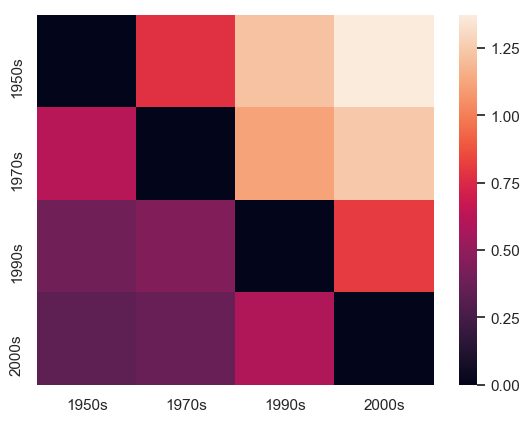

In [421]:
L = []
for p in corpora_4_category:
    l = []
    for q in corpora_4_category:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = ["1950s", "1970s", "1990s", "2000s"], 
                       index = ["1950s", "1970s", "1990s", "2000s"])
ax = sns.heatmap(div)
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


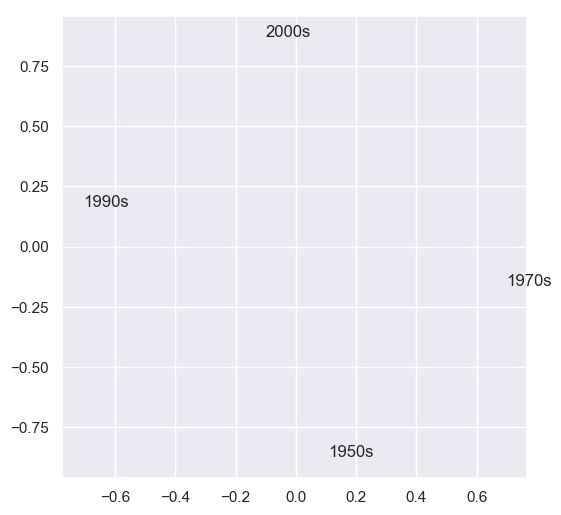

In [422]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(["1950s", "1970s", "1990s", "2000s"]):
    ax.annotate(txt, (x[i],y[i]))

Using KL all 4 decades seem very different in their scripts.

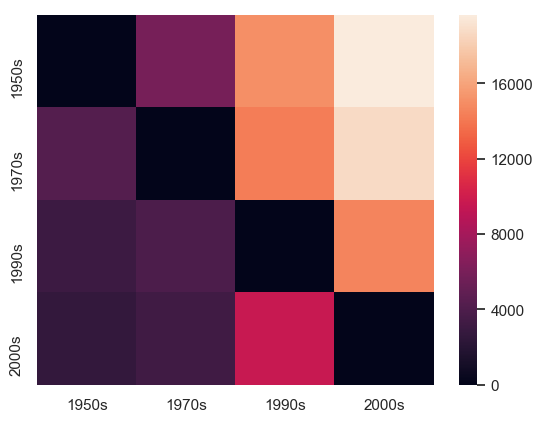

In [423]:
L = []
for p in corpora_4_category:
    l = []
    for q in corpora_4_category:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = ["1950s", "1970s", "1990s", "2000s"], 
                       index = ["1950s", "1970s", "1990s", "2000s"])
ax = sns.heatmap(div)
plt.show()

The colors indicating divergence are in general darker. 
Also the multi-dimensional scaling plot shows that the 4 years' movie scripts are pretty spread out. Not sure if I am reading it correctly, but it appears that 1950s and 2000s are most different in their scripts because of the darker colors?

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


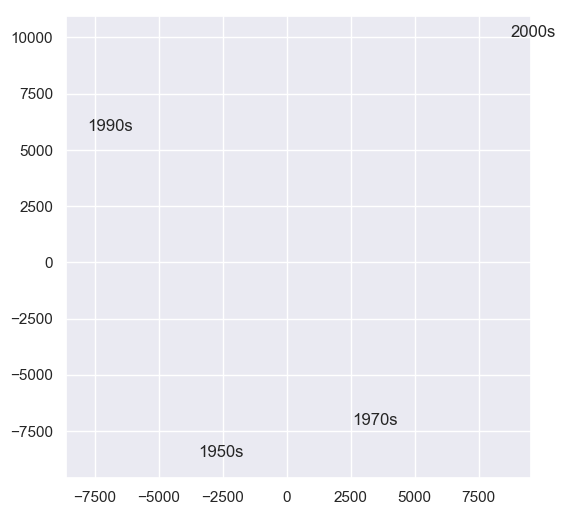

In [407]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(["1950s", "1970s", "1990s", "2000s"]):
    ax.annotate(txt, (x[i],y[i]))

Using Chi-sq, we see that 1950s and 1970s seem more similar than with the KL method.

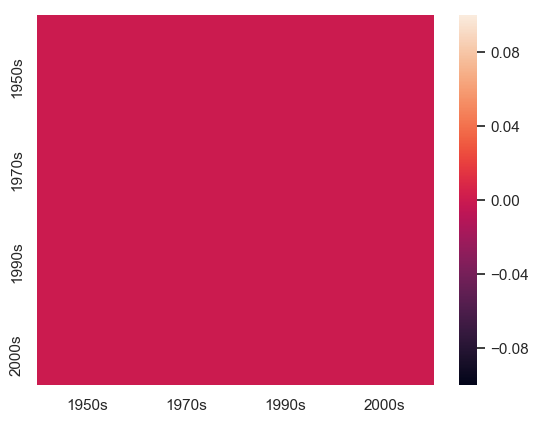

In [424]:
L = []
for p in corpora_4_category:
    l = []
    for q in corpora_4_category:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = ["1950s", "1970s", "1990s", "2000s"], 
                       index = ["1950s", "1970s", "1990s", "2000s"])
ax = sns.heatmap(div)
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  old_stress = stress / dis
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:124: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:129: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis


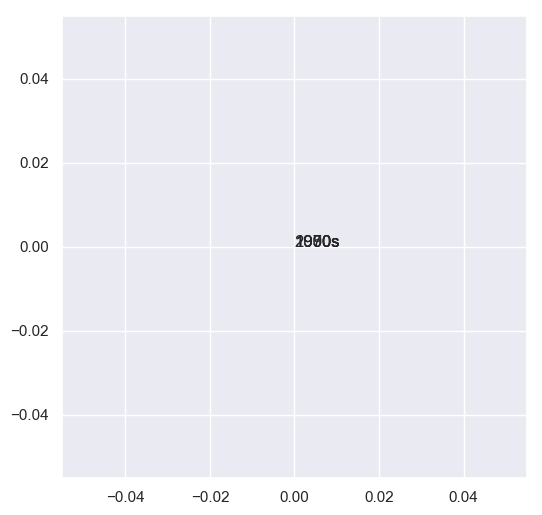

In [409]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(["1950s", "1970s", "1990s", "2000s"]):
    ax.annotate(txt, (x[i],y[i]))

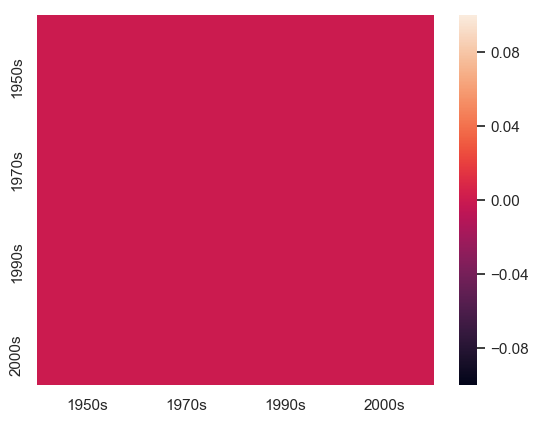

In [410]:
L = []
for p in corpora_4_category:
    l = []
    for q in corpora_4_category:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = ["1950s", "1970s", "1990s", "2000s"], 
                       index = ["1950s", "1970s", "1990s", "2000s"])
ax = sns.heatmap(div)
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  old_stress = stress / dis
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:124: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:129: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis


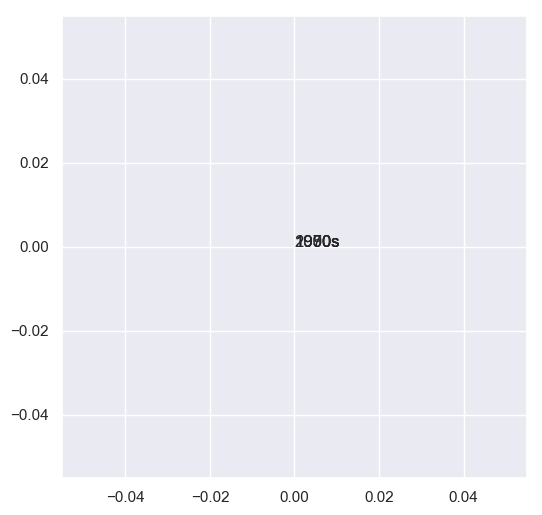

In [411]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(["1950s", "1970s", "1990s", "2000s"]):
    ax.annotate(txt, (x[i],y[i]))

### 1950 normalizations

Looking at the normalizations in just the 1950 films

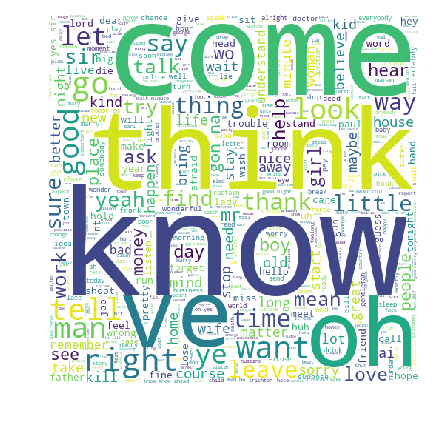

In [417]:
#Normalized Texts
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(only_1950s['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("text_word_cloud.pdf", format = 'pdf')

In [394]:
corpora = []
for index, row in only_1950s.iterrows():
    corpora.append(row['Tokenized'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [395]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [412]:
len(corpora)

31

In [399]:
fileids = list(only_1950s['Movie Name'])

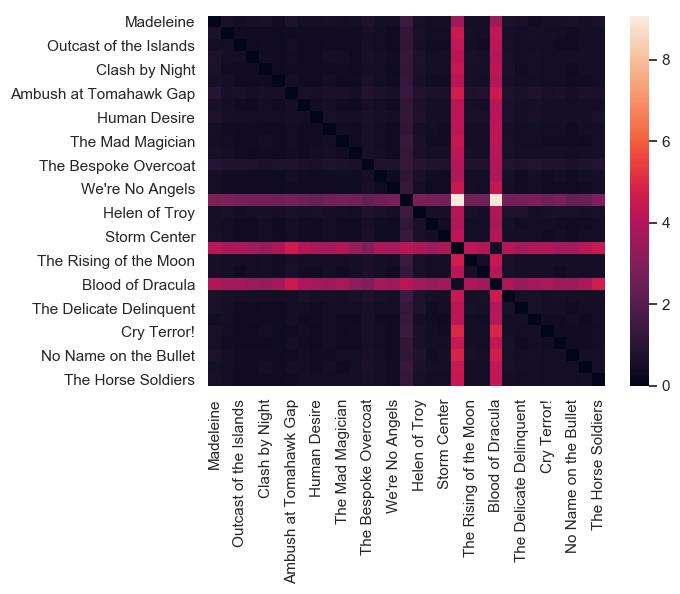

In [400]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


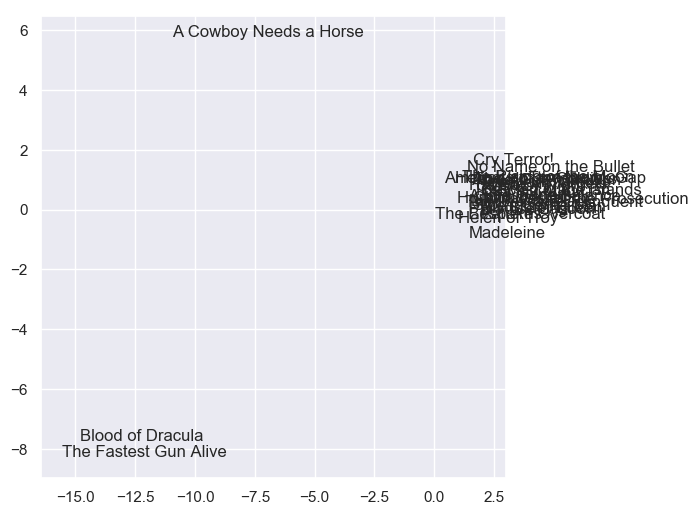

In [401]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

### KL

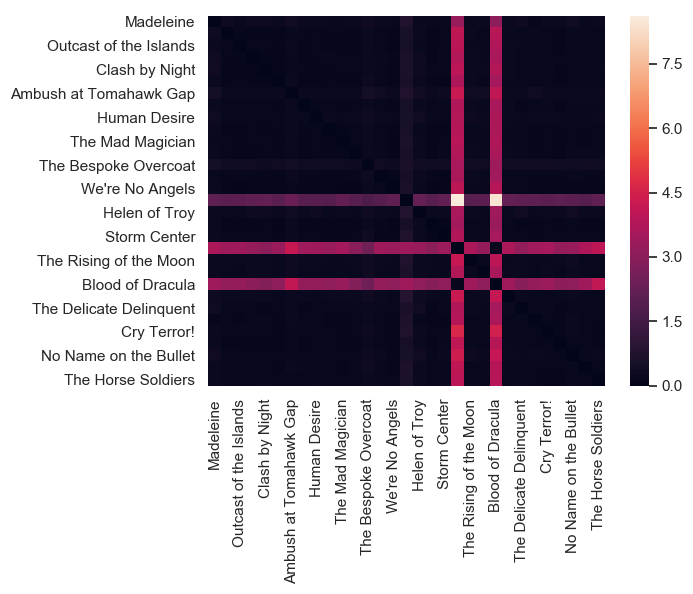

In [402]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

In [403]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


Now we compute the same for the assymmetric $\chi^2$ Divergence.

#### $\chi^2$ 

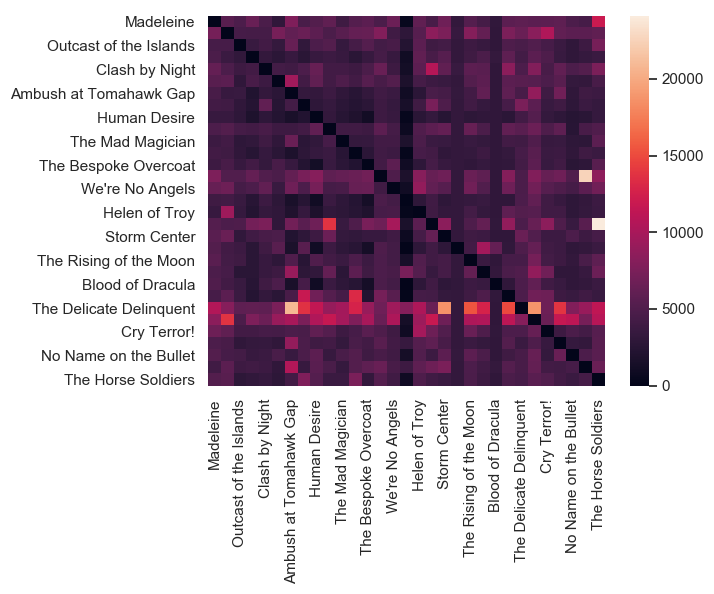

In [404]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

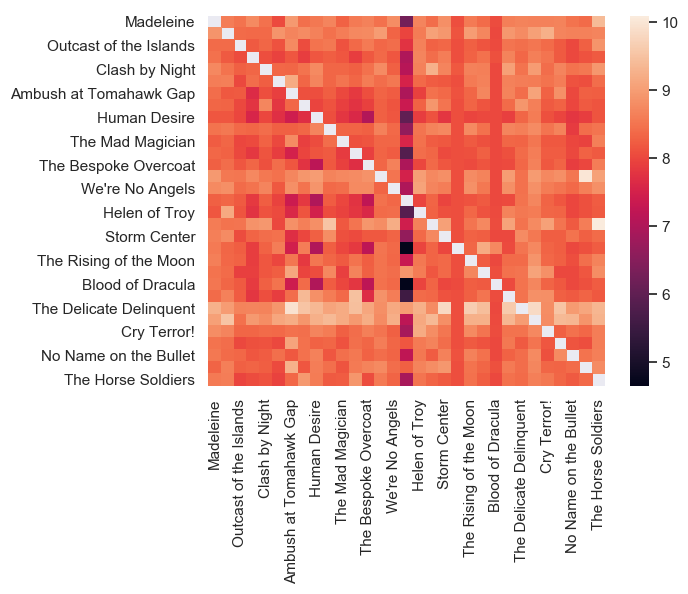

In [405]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

### KS

In [413]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

In [414]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

### Wasserstein

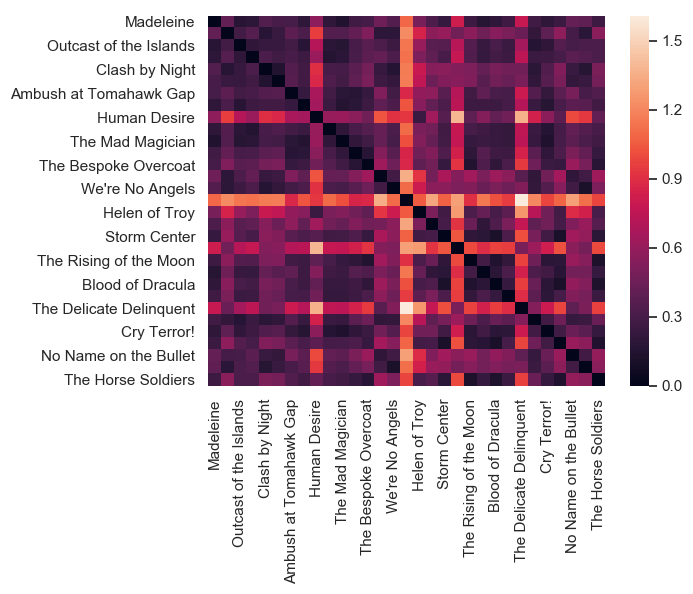

In [415]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

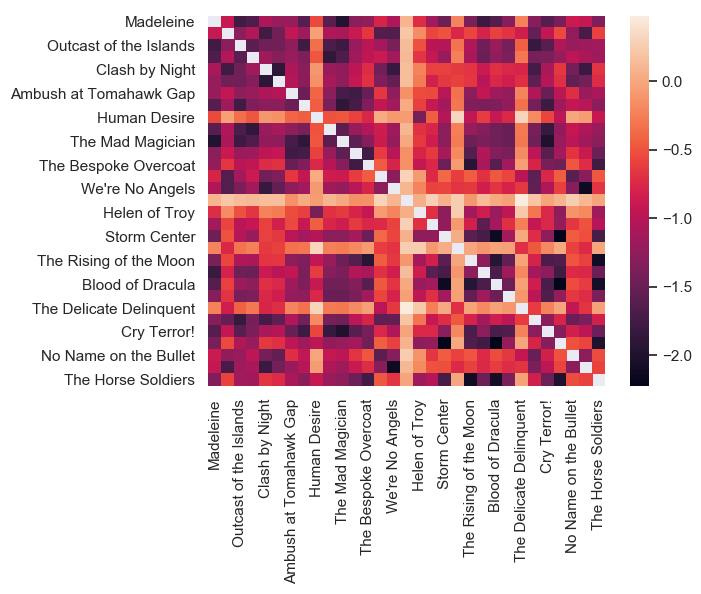

In [416]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()